In [1]:
#library(PROPER)
library(limma)
library(Seurat)
library(ggplot2)
library(Matrix)
library(rhdf5)
library(sva)
library(matrixStats)
library(VennDiagram)
#library(qvalue)
#library(fdrtool)
#library(DSS)
#library(DESeq2) 
source("limma-voom.R")

get_categories <- function(meta) {
    names = meta$codes
    for (i in 1:length(meta$categories)) {
        name = meta$categories[i]
        names[meta$codes==(i-1)] = name
    }
    return(names)
}

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:genefilter’:

    rowSds, rowVars


Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘futile.logger’


The following object is masked from ‘package:mgcv’:

    scat




In [2]:
# remember to change to your own data path
file_path = "/storage10/shuchen/JerberData/alltime_fiaj_12100_5000.mtx"
meta_path = "/storage10/shuchen/JerberData/alltime_fiaj_12100_5000.h5"
h5ls(meta_path)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,X,H5I_GROUP,,
1,/X,data,H5I_DATASET,FLOAT,10938528
2,/X,indices,H5I_DATASET,INTEGER,10938528
3,/X,indptr,H5I_DATASET,INTEGER,12101
4,/,layers,H5I_GROUP,,
5,/,obs,H5I_GROUP,,
6,/obs,celltype,H5I_GROUP,,
7,/obs/celltype,categories,H5I_DATASET,STRING,11
8,/obs/celltype,codes,H5I_DATASET,INTEGER,12100


In [3]:
data <- t(readMM(file_path))
cell_type <- h5read(meta_path, name="obs/celltype")
sample_id <- h5read(meta_path, name="obs/sample_id")
pool_id <- h5read(meta_path, name="obs/pool_id")
time_point <- h5read(meta_path, name="obs/time_point")
treatment <- h5read(meta_path, name="obs/treatment")
gene <- h5read(meta_path, name="var/index")

cell_type <- get_categories(cell_type)
sample_id <- get_categories(sample_id)
pool_id <- get_categories(pool_id)
time_point <- get_categories(time_point)
treatment <- get_categories(treatment)

In [4]:
dim(data)

[1]  5000 12100

In [5]:
data_pool <- ComBat(data, pool_id)
data_sample <- ComBat(data, sample_id)

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 694 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found30batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [6]:
# a metadata dataframe for the variables that we are interested in
meta = data.frame(sample_id=as.factor(sample_id), cell_type=as.factor(cell_type), time_point=as.factor(time_point), treatment=as.factor(treatment))
meta

sample_id,cell_type,time_point,treatment
<fct>,<fct>,<fct>,<fct>
5245STDY7487301,P_FPP,D11,NONE
5245STDY7487301,NB,D11,NONE
5245STDY7487301,FPP,D11,NONE
5245STDY7487301,FPP,D11,NONE
5245STDY7487301,FPP,D11,NONE
5245STDY7487301,NB,D11,NONE
5245STDY7487301,P_FPP,D11,NONE
5245STDY7487301,FPP,D11,NONE
5245STDY7487301,FPP,D11,NONE


In [7]:
# pseudobulk metadata with 200 bulks in total
bulk_meta = unique(meta)
bulk_meta

,sample_id,cell_type,time_point,treatment
,<fct>,<fct>,<fct>,<fct>
1,5245STDY7487301,P_FPP,D11,NONE
2,5245STDY7487301,NB,D11,NONE
3,5245STDY7487301,FPP,D11,NONE
170,5245STDY7487302,FPP,D11,NONE
171,5245STDY7487302,NB,D11,NONE
172,5245STDY7487302,P_FPP,D11,NONE
414,5245STDY7520697,Epen1,D30,NONE
416,5245STDY7520697,FPP,D30,NONE
419,5245STDY7520697,P_FPP,D30,NONE


In [8]:
# Aggregate counts by groups defined by bulk samples
aggr_data <- aggregate(t(data_sample), by = list(meta$sample_id, meta$cell_type, meta$time_point, meta$treatment), FUN = mean)
aggr_data = t(aggr_data[,-c(1:4)])
aggr_data

V1,0.191719905,0.225081077,0.162766345,0.166262157,0.176474695,0.158062488,0.211974348,0.054531610,0.196178500,0.266034068,⋯,2.132007e-01,0.1090005266,0.066145175,0.5404319444,0.560340548,0.021733614,0.4243585999,0.1653716228,0.347673447,0.0816923762
V2,0.137319498,0.158924827,0.157384685,0.176952880,0.146981792,0.157367751,0.378769880,0.286199527,0.493424680,0.262153763,⋯,1.030641e-01,0.2695307787,0.223112937,0.1441313447,-0.016609896,-0.004936423,0.0683146965,0.1279551684,-0.026159981,0.0912430920
V3,0.019236314,0.005727453,0.016927536,0.010041430,0.012796381,0.007968310,0.056490719,0.000000000,0.025831192,0.000000000,⋯,0.000000e+00,0.0000000000,0.043909113,0.0783447615,0.000000000,0.000000000,0.0000000000,0.0000000000,0.000000000,0.0000000000
V4,0.421741854,0.398798216,0.411404657,0.392135204,0.382939337,0.415041156,0.437999153,0.337540534,0.241966527,0.099361303,⋯,8.046668e-01,1.1968468515,0.587986629,1.1455881988,0.101434363,1.531850868,0.9776267908,0.9386507619,0.440919323,0.5169953899
V5,0.142969485,0.173285114,0.167272263,0.169098481,0.162564702,0.164315573,0.267114579,0.116483763,0.109379640,0.185806211,⋯,8.225867e-05,0.0106806895,-0.013477506,0.0117243826,0.020672580,0.401893464,0.2084443138,0.1255679712,0.284975813,0.0117243826
V6,0.027572953,0.098156831,0.071569604,0.074979854,0.074851529,0.049847043,0.195639706,0.009853248,0.104578516,0.066868691,⋯,-1.208909e-02,0.0685199843,0.101757331,0.0567658959,0.010768658,0.015367733,0.1288996609,-0.0027005896,-0.012622484,0.0979700088
V7,0.024882293,0.015532170,0.020640133,0.013100470,0.019669140,0.029085144,0.029863517,0.020208505,-0.005824091,0.049502081,⋯,6.676938e-03,0.0751095430,-0.002311821,0.0698221044,0.005329245,0.009477080,0.0066769381,-0.0028047125,-0.002311821,0.0019881176
V8,0.065845947,0.068709619,0.058589346,0.059710505,0.064716613,0.061416987,0.050770324,0.032900479,0.016348428,0.071573011,⋯,5.737363e-03,0.0135097207,0.024849133,0.0153545541,0.015189393,0.031920762,0.0057373631,0.0135097207,0.024849133,-0.0036270674
V9,0.053950605,0.052463127,0.061833374,0.052016115,0.046259944,0.046555779,0.176109848,0.210698468,0.258035732,0.154093041,⋯,5.667259e-01,0.1154473870,0.341255538,0.3117900468,0.005376717,0.009831883,0.0098427995,0.0078110557,0.329614489,0.0079800880
V10,0.101154960,0.070374801,0.092339398,0.089919093,0.069289358,0.071546080,0.036262585,0.033032222,0.099387043,0.015311886,⋯,4.357946e-03,0.0132209601,0.012180142,0.0239430858,0.016735734,0.003167045,0.3382582988,0.1039116100,0.012180142,0.0239430858
V11,0.016997098,0.029050942,0.035461086,0.029379923,0.020242037,0.025351697,0.040146837,0.005885659,0.005554295,0.085680607,⋯,-8.685926e-03,-0.0111861974,0.036165651,0.0579250886,0.002781330,0.002751773,-0.0086859260,0.0392613130,-0.009513863,0.2438767949


In [9]:
dim(data_pool)

[1]  5000 12100

In [11]:
aggr_data_pos = aggr_data - min(aggr_data)
data_pos = data_sample - min(data_sample)

In [284]:
# change bulk metadata to characters for future use
bulk_meta <- as.data.frame(lapply(bulk_meta, function(x) as.character(x)))
bulk_meta

sample_id,cell_type,time_point,treatment
<chr>,<chr>,<chr>,<chr>
5245STDY7487301,P_FPP,D11,NONE
5245STDY7487301,NB,D11,NONE
5245STDY7487301,FPP,D11,NONE
5245STDY7487302,FPP,D11,NONE
5245STDY7487302,NB,D11,NONE
5245STDY7487302,P_FPP,D11,NONE
5245STDY7520697,Epen1,D30,NONE
5245STDY7520697,FPP,D30,NONE
5245STDY7520697,P_FPP,D30,NONE


In [45]:
# aggregated data
data_DA <- aggr_data_pos[, which(bulk_meta$time_point=="D52" & bulk_meta$cell_type=="DA")]
meta_DA <- bulk_meta[which(bulk_meta$time_point=="D52" & bulk_meta$cell_type=="DA"),]$treatment
dim(data_DA)
data_nonDA <- aggr_data_pos[, which(bulk_meta$time_point=="D52" & bulk_meta$cell_type!="DA")]
meta_nonDA <- bulk_meta[which(bulk_meta$time_point=="D52" & bulk_meta$cell_type!="DA"),]$treatment
# data_nonDA <- aggr_data_pos[, which(bulk_meta$time_point=="D52" & bulk_meta$cell_type=="Epen1")]
# meta_nonDA <- bulk_meta[which(bulk_meta$time_point=="D52" & bulk_meta$cell_type=="Epen1"),]$treatment
dim(data_nonDA)

[1] 5000   16

[1] 5000  113

In [296]:
table(cell_type[which(time_point=="D52")])


  Astro      DA   Epen1   Epen2     FPP   P_FPP    Sert U_Neur1 U_Neur3 
   2937     434    1590      56    1085     720       9     425      43 

In [53]:
# single cell data
data_DA <- data_pos[,which(time_point=="D52" & cell_type=="DA")]
meta_DA <- treatment[which(time_point=="D52" & cell_type=="DA")]
dim(data_DA)
data_nonDA <- data_pos[,which(time_point=="D52" & cell_type!="DA")]
meta_nonDA <- treatment[which(time_point=="D52" & cell_type!="DA")]
# data_nonDA <- data_pos[,which(time_point=="D52" & cell_type=="FPP")]
# meta_nonDA <- treatment[which(time_point=="D52" & cell_type=="FPP")]
dim(data_nonDA)

[1] 5000  434

[1] 5000 6865

In [54]:
# down_sample for non-DA 
set.seed(1234)
nonDA_down = sample(1:ncol(data_nonDA), ncol(data_DA))
data_nonDA <- data_nonDA[,nonDA_down]
meta_nonDA <- meta_nonDA[nonDA_down]
dim(data_nonDA)

[1] 5000  434

In [55]:
res_DA <- DE_limmavoom(counts=data_DA, group=as.factor(meta_DA), contrfml = "groupROT-groupNONE", 
                    cutoff=1.0, thres_type="adjp",
                    p_thres=0.05, lfc_thres=1.0, adj_method = "BH")

[1] "5000 out of 5000 genes left after filtering low-expressed genes"
           Contrasts
Levels      groupROT-groupNONE
  groupNONE                 -1
  groupROT                   1


In [56]:
res_nonDA <- DE_limmavoom(counts=data_nonDA, group=as.factor(meta_nonDA), contrfml = "groupROT-groupNONE", 
                    cutoff=1.0, thres_type="adjp",
                    p_thres=0.05, lfc_thres=1.0, adj_method = "BH")

[1] "5000 out of 5000 genes left after filtering low-expressed genes"
           Contrasts
Levels      groupROT-groupNONE
  groupNONE                 -1
  groupROT                   1


In [42]:
sum(toptable$adj.P.Val < 0.05 & toptable$logFC >= 0)

[1] 10

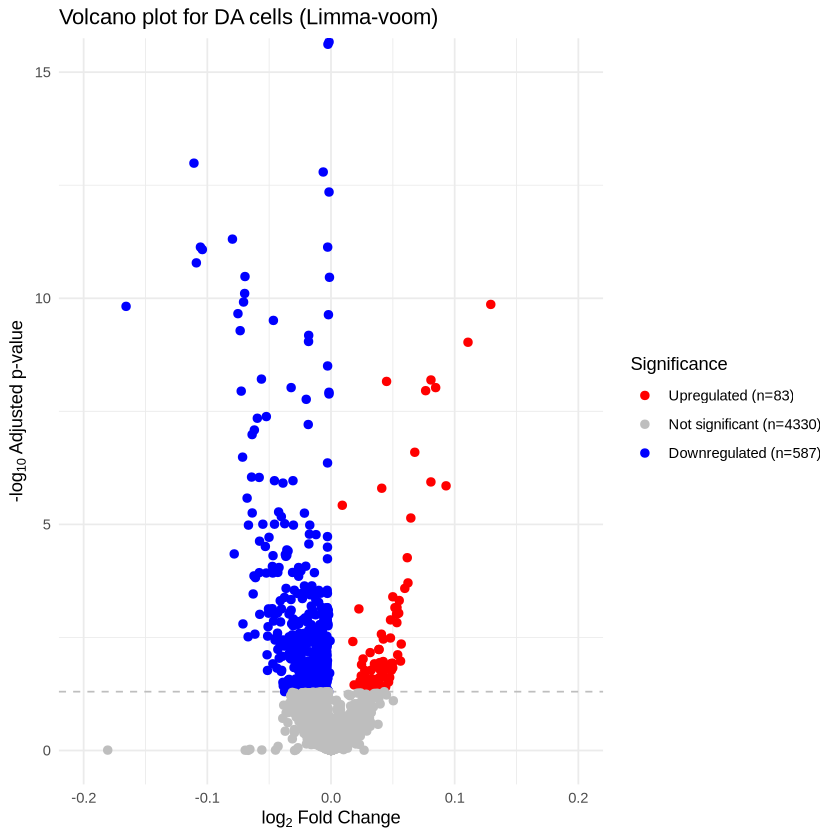

In [62]:
toptable <- res_DA$toptable
toptable$color <- ifelse(toptable$adj.P.Val < 0.05, ifelse(toptable$logFC < 0, "red", "blue"), "grey")
p <- ggplot(data = toptable, aes(x = logFC, y = -log10(adj.P.Val), col = color)) +
    geom_vline(xintercept = c(-0.6, 0.6), col = "grey", linetype = 'dashed') +
    geom_hline(yintercept = -log10(0.05), col = "grey", linetype = 'dashed') +
    geom_point(size = 2) +
    scale_color_manual(values = c("red", "grey", "blue"), 
                       # breaks = c("Downregulated", "Not significant", "Upregulated")#,  # Specify order of colors
                       labels = c("Upregulated (n=83)", "Not significant (n=4330)", "Downregulated (n=587)")
                      ) +
    coord_cartesian(ylim = c(0, 15), xlim = c(-0.2, 0.2)) +
    labs(color = 'Significance',
         x = expression("log"[2]*" Fold Change"),
         y = expression("-log"[10]*" Adjusted p-value")) +
    ggtitle('Volcano plot for DA cells (Limma-voom)') +
    theme_minimal()
p

In [269]:
res_DA$toptable
res_nonDA$toptable

,logFC,AveExpr,t,P.Value,adj.P.Val,B,genes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
V3778,0.1708713,7.550751,3.928176,0.0008655312,0.6309062,-1.036717,V3778
V4677,-0.1793596,7.387237,-3.896345,0.0009316065,0.6309062,-1.324592,V4677
V1229,0.2556475,7.565632,3.798068,0.0011690166,0.6309062,-1.319518,V1229
V1750,-0.2416926,7.373424,-3.667829,0.0015785753,0.6309062,-1.632420,V1750
V728,0.1989336,7.558458,3.651801,0.0016379327,0.6309062,-1.481199,V728
V627,-0.1895501,7.371084,-3.604178,0.0018276517,0.6309062,-1.569957,V627
V3572,-0.1703861,7.401813,-3.575694,0.0019513491,0.6309062,-1.716323,V3572
V1405,-0.2345507,7.322678,-3.495751,0.0023444154,0.6309062,-2.105428,V1405
V595,0.1789212,7.518109,3.453482,0.0025828046,0.6309062,-1.964916,V595


,logFC,AveExpr,t,P.Value,adj.P.Val,B,genes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
V2987,-0.18084387,7.417766,-5.946235,2.952635e-08,0.0001476317,8.669240,V2987
V4933,-0.18018669,7.363738,-5.774177,6.567222e-08,0.0001641806,7.897263,V4933
V614,-0.14006144,7.331662,-5.263000,6.567080e-07,0.0008716610,5.756684,V614
V1877,-0.16074460,7.404232,-5.211282,8.236491e-07,0.0008716610,5.558870,V1877
V370,-0.10628053,7.400231,-5.198300,8.716610e-07,0.0008716610,5.504416,V370
V2838,-0.09053297,7.320583,-5.148712,1.081491e-06,0.0009012428,5.293058,V2838
V3913,-0.10439389,7.315017,-4.926349,2.803710e-06,0.0017926176,4.417980,V3913
V862,-0.13002193,7.362657,-4.892148,3.239079e-06,0.0017926176,4.289092,V862
V1909,-0.27880801,7.362213,-4.873642,3.501340e-06,0.0017926176,4.216574,V1909


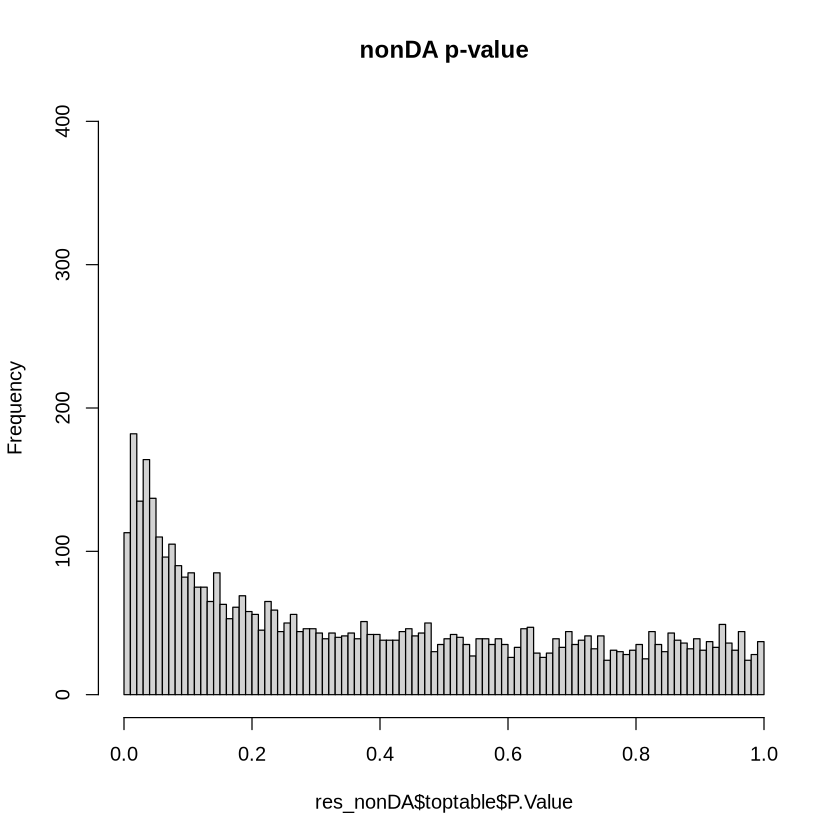

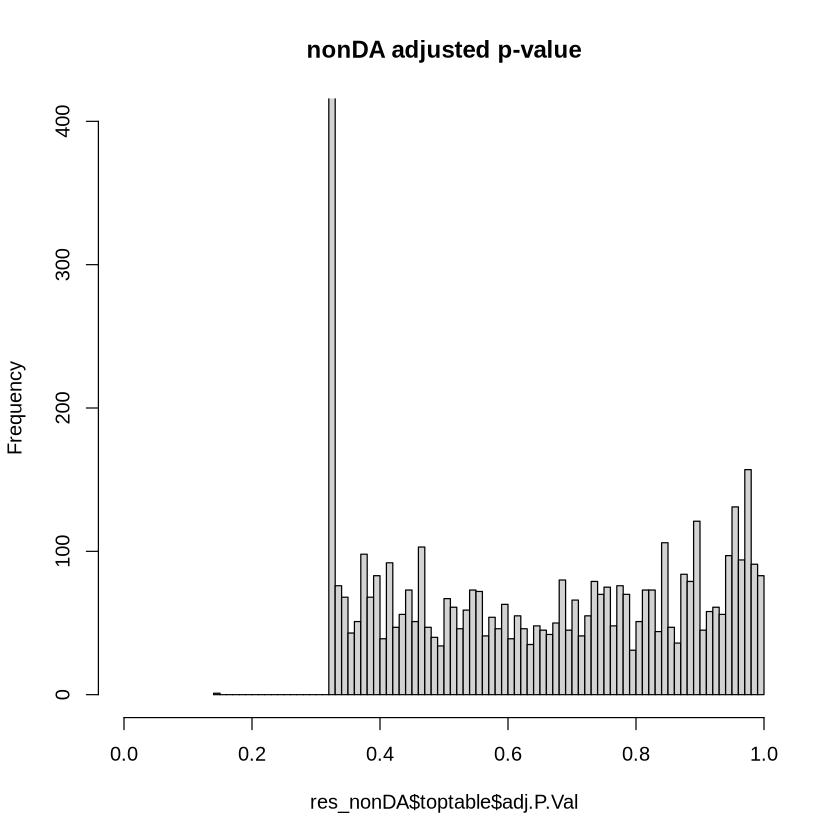

In [52]:
hist(res_nonDA$toptable$P.Value, breaks=100, xlim=c(0.0, 1.0), ylim=c(0, 400), main="nonDA p-value")
hist(res_nonDA$toptable$adj.P.Val, breaks=100, xlim=c(0.0, 1.0), ylim=c(0, 400), main="nonDA adjusted p-value")

In [26]:
sum(res_DA$toptable$adj.P.Val < 0.05)
sum(res_nonDA$toptable$adj.P.Val < 0.05)

[1] 670

[1] 118

In [293]:
length(res_DA$de_genes)
length(res_nonDA$de_genes)

[1] 0

[1] 324

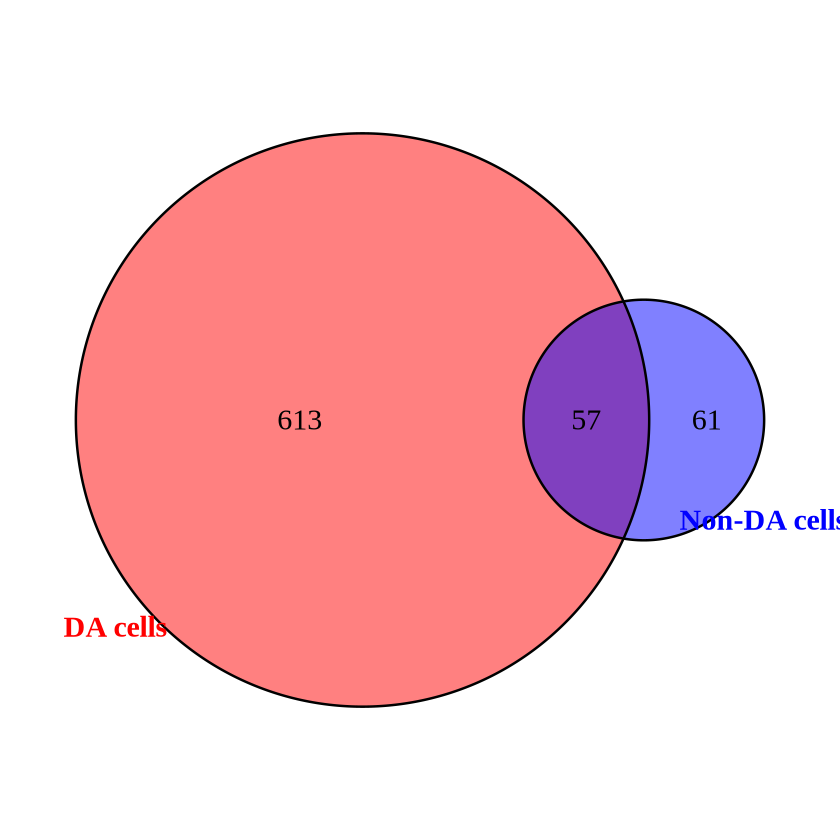

In [27]:
# Define the two vectors
nonDA_genes <- gene[as.numeric(res_nonDA$de_genes)]
DA_genes <- gene[as.numeric(res_DA$de_genes)]
## A fancier version

# Create the Venn diagram with smaller circles
venn.plot <- venn.diagram(
  x = list(nonDA = nonDA_genes, DA = DA_genes),
  category.names = c("Non-DA cells", "DA cells"),
  filename = NULL,
  fill = c("blue", "red"),
  alpha = 0.5,
  cat.col = c("blue", "red"),
  cat.fontface = "bold",
  cat.fontfamily = "serif",
  cat.cex = 1.5,
  cex = 1.5,
  fontfamily = "serif",
  scaled = TRUE, # Set scaled to TRUE to make circles smaller
  margin = 0.05 # Set margin between circles
)

# Plot the Venn diagram
grid.draw(venn.plot)

In [ ]:
# complete.results_Cheung <- na.omit(results_Cheung)
res_fdr <- fdrtool(res$toptable$t, statistic = "normal", plot = TRUE)

hist(res$toptable$t, breaks=20)
hist(res_fdr$pval, breaks=20)
hist(res_fdr$lfdr, breaks=20)
hist(res_fdr$qval, breaks=20)

In [ ]:
res$predicted <- ifelse(1:nrow(sim.data$counts) %in% res$de_genes, "DE", "Not DE")
res$actual <- ifelse(1:nrow(sim.data$counts) %in% sim.data$DEid, "DE", "Not DE")
confusion_matrix <- table(res$actual, res$predicted)
sum(res$predicted=="DE")
sum(res$actual=="DE")

metrics <- calculate_metrics(confusion_matrix)
metrics